<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/colab/Buckley_Leverett_Basic_Sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 水油置換問題の感度解析（Buckley-Leverettの解法）

Version 0.2 (Oct. 2019)

油で満たされている多孔質媒体に水を圧入し水攻するとき，一次元／非圧縮／非混和条件を仮定すると，Buckley-Leverettの解法により、ある時間に対する飽和率分布を解析的に求めてみました．[Buckley-Leverett Solution for water-oil displacement problem](https://github.com/mayuneko-re/notebook/blob/master/Buckley_Leverett_Basic.ipynb)

ここでは，種々のパラメ―タによる感度を確認してみたいと思います．


**ライブラリのインポート**

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt

計算には，https://github.com/mayuneko-re/notebook.git にある buckley_leverett.py を使用します．[Buckley-Leverett Solution for water-oil displacement problem](https://github.com/mayuneko-re/notebook/blob/master/Buckley_Leverett_Basic.ipynb) にある計算をスクリプト化したものです．Colaboratory上で `wget` してそのまま使っています．


In [2]:
!rm -r buckley_leverett.py
!wget -nv https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/buckley_leverett.py
from buckley_leverett import BL

rm: cannot remove 'buckley_leverett.py': No such file or directory
2019-11-05 14:03:58 URL:https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/buckley_leverett.py [6348/6348] -> "buckley_leverett.py" [1]


## 感度解析

### 水と油の粘度の違いによる影響

相対浸透率が同じ場合で、粘度が異なる場合を考えます．ここでは，圧入水の粘度は同じとし，油の粘度を変えてみます．

In [0]:
d_core = {'Swc':0.2, 'Sor':0.1, 'krw0':0.2, 'kro0':0.8, 'nw':2, 'no':3}
d_f1 = {'muw':0.5, 'muo':1, 'label':'Low oil viscosity case'}
d_f2 = {'muw':0.5, 'muo':10, 'label':'Intermediate oil viscosity case'}
d_f3 = {'muw':0.5, 'muo':50, 'label':'High oil viscosity case'}

dl = [{**d, **d_core} for d in [d_f1, d_f2, d_f3]]

bls = [BL(**d) for d in dl]

for bl in bls:
    bl.calc()

相対浸透率をみてみます．

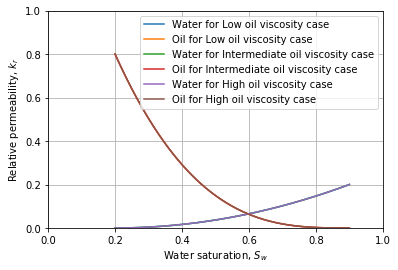

In [4]:
# Plot Relative permeability
def plot_kr(bls):
    for bl in bls:
        plt.plot(bl.Sw, bl.krw, label='Water for '+bl.label)
        plt.plot(bl.Sw, bl.kro, label='Oil for '+bl.label)
        plt.legend()
        plt.xlabel('Water saturation, $S_w$')
        plt.ylabel('Relative permeability, $k_r$')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.grid()


plot_kr(bls)

相対浸透率は飽和率の関数としてモデル化しているため，粘度の違いはありません．次にフラクショナルフローをみます．

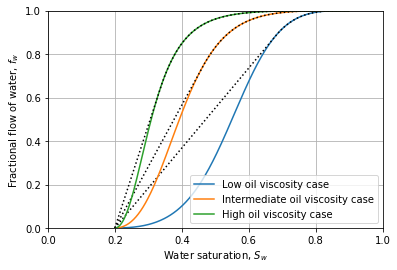

In [5]:
# Fractional flow of water
def plot_fw(bls):
    for bl in bls:
        plt.plot(bl.Sw, bl.fw, label=bl.label)
        plt.plot(bl.Sw, bl.fw_wSF, 'k:')
        plt.legend()
        plt.xlabel('Water saturation, $S_w$')
        plt.ylabel('Fractional flow of water, $f_w$')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.grid()

plot_fw(bls)

フラクショナルフローには流体の粘度の違いが反映されています．油（被置換流体）の粘度が高くなる，あるいは水（置換流体）の粘度が低くなると，水のフラクショナル関数は左にシフトし水が流れやすくなっています．次にある時間の飽和率分布をみてみます．

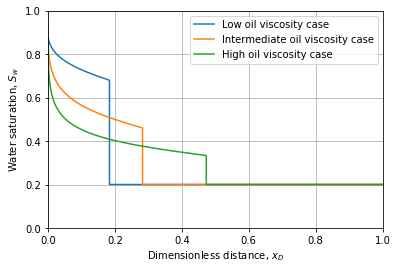

In [6]:
# Saturation profile at specific time
def plot_Sw(bls):
    for bl in bls:
        xD, Sw = bl.get_Sw_profile(tD=0.1)
        plt.plot(xD, Sw, label=bl.label)
        plt.legend()
        plt.xlabel('Dimensionless distance, $x_D$')
        plt.ylabel('Water saturation, $S_w$')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.grid()

plot_Sw(bls)

In [7]:
from matplotlib import animation, rc
from IPython.display import HTML

def plot_Sw_anim(bls):

    # First set up the figure, the axes, and the plot element
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    plt.close()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('Dimensionless distance, $x_D$')
    ax.set_ylabel('Water saturation, $S_w$')
    ax.grid()

    line_bls = [ax.plot([],[], label=bl.label)[0] for bl in bls]
    ax.legend()
         
    # animation function: this is called sequentially
    def animate(i):
        tD = i/100
        ax.set_title('$t_D$ = {:.2f} PV'.format(tD))
        for (bl,line_bl) in zip(bls,line_bls):
            xD, Sw = bl.get_Sw_profile(tD=tD)
            line_bl.set_data(xD, Sw)
        return (*line_bls,)

    anim = animation.FuncAnimation(fig, animate, frames=100, interval=100, blit=True)
    rc('animation', html='jshtml')
    
    return anim
    

plot_Sw_anim(bls)

油の粘度が高いと，ショックフロントでの飽和率の不連続は小さくなり，フロントは速く進展します．そのため，早期のブレークスルーが起こることになります．では，回収率の推移をみてみます．

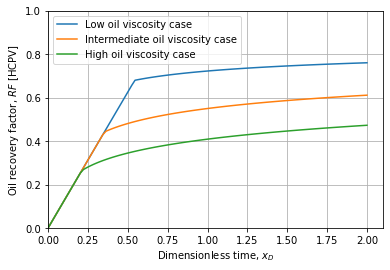

In [8]:
# Saturation profile at specific time
def plot_RF(bls):
    tD = np.linspace(start=0, stop=2, num = 100)
    for bl in bls:
        plt.plot(tD, bl.get_oil_RF(tD), label=bl.label)
        plt.legend()
        plt.xlabel('Dimensionless time, $x_D$')
        plt.ylabel('Oil recovery factor, $RF$ [HCPV]')
        plt.xlim(0,)
        plt.ylim(0,1)
        plt.grid()

plot_RF(bls)

油の粘度が高い場合，ブレークスルーが早期に起こるため，時間に対する回収率は低く推移することになっています．

これらのことから，重質な油への水攻法に比べ，軽質な油への水攻法のほうが高い効率が期待できそうです．

### 濡れ性（相対浸透率）の違い

今度は粘度はそのままに，濡れ性を変えた場合をみてみます．濡れ性の違いは相対浸透率の違いで表現します．

In [0]:
d_core1 = {'Swc':0.1, 'Sor':0.3, 'krw0':0.4, 'kro0':0.8, 'nw':2, 'no':3, 'label':'Oil wet case'}
d_core2 = {'Swc':0.2, 'Sor':0.2, 'krw0':0.2, 'kro0':0.8, 'nw':2, 'no':3, 'label':'Intermediate wet case'}
d_core3 = {'Swc':0.3, 'Sor':0.1, 'krw0':0.1, 'kro0':0.8, 'nw':2, 'no':3, 'label':'Water wet case'}
d_f = {'muw':0.5, 'muo':10}

dl = [{**d_f, **d} for d in [d_core1, d_core2, d_core3]]

bls = [BL(**d) for d in dl]

for bl in bls:
    bl.calc()

まず，相対浸透率をみてみます．

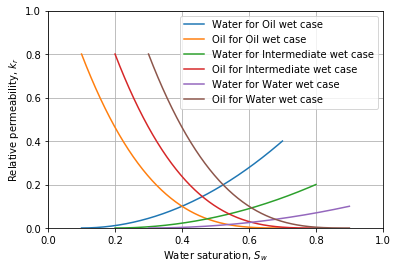

In [10]:
plot_kr(bls)

濡れ性を反映して相対浸透率の形を変えています．次にフラクショナルフローをみてみます．

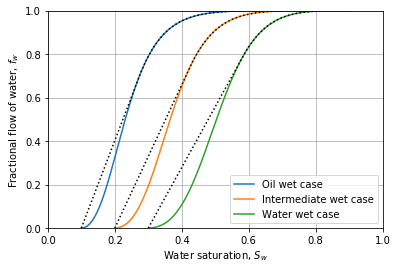

In [11]:
plot_fw(bls)

濡れ性の違いによりフラクショナルフローの形状が異なることが分かります．次にある時間での飽和率分布をみてみます．

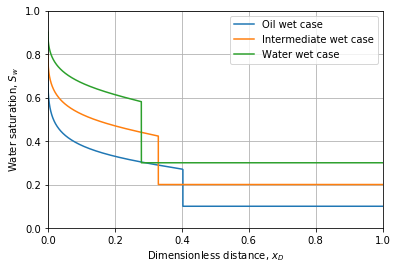

In [12]:
plot_Sw(bls)

In [13]:
plot_Sw_anim(bls)

油濡れな岩石の場合，ショックフロントが速く進展し，早期にブレークスルーが起こることが分かります．一方，水濡れの場合，比較的ピストンライクな置換が起こり，ブレークスルーが遅くなっています．最後に回収率の推移をみてみます．

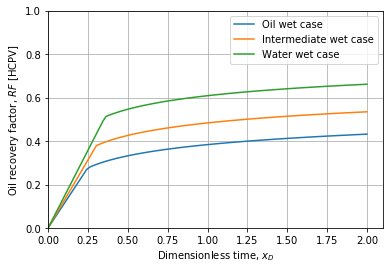

In [14]:
plot_RF(bls)

岩石の濡れ性の違いにより，油の回収挙動が変化することが分かります．Oil wetなコアの場合，ショックフロントが速く進展し，早期にブレークスルーが起こり，回収率が低くなることがわかります．一方，水濡れの場合，比較的ピストンライクな置換が起こり，ブレークスルーが遅くなった結果，油の回収率も高くなっていることがわかります．

Oil wetな岩石での水攻法に比べ，Water wetな岩石での水攻法のほうが高い効率が期待できそうです．

*End of notebook...*